In [1]:
using Revise
using Turing, MCMCChains
using XLSX
using DataFrames, TimeSeries
using StatsPlots
using LinearAlgebra
using CSV
using StatsBase
include("utils.jl")
include("financial_bvar_temp.jl")
using .FinancialBVAR

In [2]:
df = DataFrame(XLSX.readtable("usa_var_data.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :Date), Dates.quarter, last)

292×11 TimeArray{Float64, 2, Date, Matrix{Float64}} 1951-12-01 to 2024-07-01
┌────────────┬──────────┬───────────┬─────────────┬──────────┬────────┬─────────
│            │ Yeld_10Y │ Price_10Y │ Stock_Price │ Dividend │ E      │ CAPE   ⋯
├────────────┼──────────┼───────────┼─────────────┼──────────┼────────┼─────────
│ 1951-12-01 │  0.02513 │   104.098 │       24.19 │  1.41333 │   2.44 │ 12.527 ⋯
│ 1952-03-01 │  0.02505 │   104.824 │       23.74 │     1.43 │    2.4 │ 12.242 ⋯
│ 1952-06-01 │  0.02415 │   106.295 │       25.08 │     1.45 │   2.34 │ 12.669 ⋯
│ 1952-09-01 │  0.02685 │   104.468 │       24.26 │  1.43667 │   2.36 │ 12.131 ⋯
│ 1952-12-01 │  0.02547 │   106.402 │       26.18 │     1.41 │    2.4 │ 13.010 ⋯
│ 1953-03-01 │  0.02735 │   105.373 │       24.71 │  1.41333 │   2.43 │ 12.163 ⋯
│ 1953-06-01 │  0.02987 │    103.86 │       24.29 │     1.42 │   2.51 │ 11.750 ⋯
│ 1953-09-01 │  0.02636 │    107.81 │       23.97 │     1.43 │   2.55 │ 11.391 ⋯
│     ⋮      │    ⋮     │     ⋮ 

In [3]:
colnames(data_source)

11-element Vector{Symbol}:
 :Yeld_10Y
 :Price_10Y
 :Stock_Price
 :Dividend
 :E
 :CAPE
 :T_Bill
 :CPI
 :Dividend_Yeld
 :Total_Stock_2
 :Total_Stock

In [4]:
returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns = merge(returns, log1p.(data_source[:T_Bill])./4)
cpi = percentchange(data_source[:CPI], :log)
real_returns = returns .- cpi
term = data_source[:Yeld_10Y] ./4 .- data_source[:T_Bill] ./4
dy = data_source[:Dividend_Yeld] #log.(data_source[:Dividend_Yeld])
data = merge(real_returns, dy, term, cpi)

291×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1952-03-01 to 2024-07-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1952-03-01 │      1.98335e-5 │     0.0107337 │  0.00772445 │     0.0602359 │ ⋯
│ 1952-06-01 │       0.0581411 │    0.00263202 │ -0.00708528 │      0.057815 │ ⋯
│ 1952-09-01 │      -0.0185027 │    -0.0173351 │  0.00423886 │     0.0592197 │ ⋯
│ 1952-12-01 │       0.0932838 │     0.0220972 │   0.0089235 │     0.0538579 │ ⋯
│ 1953-03-01 │      -0.0437093 │   -0.00972202 │  0.00497517 │     0.0571967 │ ⋯
│ 1953-06-01 │      -0.0100139 │    -0.0219485 │ -0.00227055 │     0.0584603 │ ⋯
│ 1953-09-01 │     -0.00574595 │     0.0298874 │ -0.00299956 │     0.0596579 │ ⋯
│ 1953-12-01 │        0.078226 │     0.0248173 │  0.00767892 │     0.0572141 │ ⋯
│     ⋮      │        ⋮        │ 

In [5]:
CSV.write("usa_data_transformed.csv", data)

"usa_data_transformed.csv"

In [32]:
start = Date(1983,03,01)
end_d = Date(2023, 12, 31)
s_data = to(from(data, start),end_d)

164×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1983-03-01 to 2023-12-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1983-03-01 │       0.0916672 │    0.00192869 │   0.0119025 │     0.0438808 │ ⋯
│ 1983-06-01 │       0.0544534 │    -0.0072674 │  0.00796388 │     0.0416766 │ ⋯
│ 1983-09-01 │      0.00376823 │    -0.0107314 │   0.0105936 │     0.0419201 │ ⋯
│ 1983-12-01 │     -0.00592333 │   -0.00188541 │    0.012673 │     0.0427885 │ ⋯
│ 1984-03-01 │      -0.0544437 │    -0.0222866 │   0.0110268 │     0.0458333 │ ⋯
│ 1984-06-01 │      -0.0397357 │    -0.0482265 │   0.0138793 │      0.048533 │ ⋯
│ 1984-09-01 │       0.0861884 │     0.0948199 │   0.0132056 │      0.045085 │ ⋯
│ 1984-12-01 │       0.0496119 │     0.0795741 │   0.0174816 │     0.0441336 │ ⋯
│     ⋮      │        ⋮        │ 

In [33]:
returns_summarystats(to(from(returns, start),end_d), 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1407,0.7827,0.1085,0.2722,-1.0147,-0.8322,-0.0084,0.0948,1.6601,0.7707,0.1484
Price_10Y,0.0862,0.5691,0.0615,0.1694,-0.2899,0.3975,-0.0545,0.0731,0.0506,0.713,0.0386
T_Bill,0.0135,0.0987,0.0333,0.0515,0.0001,0.3215,0.0049,0.973,-0.9746,2.4754,0.0327


In [34]:
returns_summarystats(s_data, 1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.0705,0.1938,0.0201,0.0616,-0.2381,-0.7014,-0.0103,0.0838,1.2529,0.2852,0.0298
Price_10Y_CPI,0.0459,0.1677,0.0084,0.0367,-0.096,0.4496,-0.0223,0.081,0.4817,0.1823,0.0034
T_Bill_CPI,0.0088,0.0255,0.0013,0.0071,-0.0268,-0.4589,-0.0038,0.3971,0.6894,0.1505,0.0025
Dividend_Yeld,0.0086,0.0485,0.023,0.0286,0.0113,0.9902,0.0174,0.9582,0.1653,2.6818,0.02
Yeld_10Y_T_Bill,0.0029,0.0099,0.0043,0.0066,-0.0034,-0.2904,0.0021,0.8695,-0.5591,1.4533,0.0044
CPI,0.0073,0.0279,0.007,0.0105,-0.0254,-0.5392,0.0035,0.1004,2.9004,0.9641,0.0072


In [35]:
returns_summarystats(s_data, 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.141,0.7753,0.0804,0.2462,-0.9526,-0.7014,-0.0413,0.0838,1.2529,0.5704,0.1194
Price_10Y_CPI,0.0918,0.6707,0.0335,0.1468,-0.3841,0.4496,-0.0891,0.081,0.4817,0.3646,0.0135
T_Bill_CPI,0.0177,0.1019,0.0053,0.0284,-0.1073,-0.4589,-0.0152,0.3971,0.6894,0.301,0.01
Dividend_Yeld,0.0172,0.1941,0.0921,0.1146,0.045,0.9902,0.0694,0.9582,0.1653,5.3636,0.08
Yeld_10Y_T_Bill,0.0059,0.0397,0.0171,0.0265,-0.0136,-0.2904,0.0082,0.8695,-0.5591,2.9065,0.0177
CPI,0.0145,0.1117,0.028,0.0422,-0.1016,-0.5392,0.0138,0.1004,2.9004,1.9281,0.0288


In [36]:
#returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns1y = from(to(percentchange(collapse(data_source[:Total_Stock, :Price_10Y],year, last), :log),end_d),start)
returns_summarystats(returns1y,1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1575,0.302,0.1085,0.2277,-0.4393,-1.3102,0.0116,-0.0296,1.9656,0.6886,0.1502
Price_10Y,0.0947,0.2605,0.0615,0.1361,-0.1786,-0.2304,0.0028,-0.0782,-0.1349,0.649,0.0668


In [37]:
returns1y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],4) ./1
returns3y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],12) ./3
returns5y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],20) ./5
returns10y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],40) ./10
cum_returns = merge(TimeSeries.rename!(returns1y, [:RealStock1y, :RealBonds1y, :RealTBill1y]), 
                    TimeSeries.rename!(returns3y, [:RealStock3y, :RealBonds3y, :RealTBill3y]), 
                    TimeSeries.rename!(returns5y, [:RealStock5y, :RealBonds5y, :RealTBill5y]),
                    TimeSeries.rename!(returns10y, [:RealStock10y, :RealBonds10y, :RealTBill10y]))
returns_summarystats(expm1.(cum_returns),1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
RealStock1y,0.1639,0.463,0.0859,0.1897,-0.3789,-0.5586,0.0094,0.773,0.5288,0.5242,0.1062
RealBonds1y,0.0895,0.221,0.0247,0.095,-0.2249,-0.2889,-0.0292,0.7335,-0.3052,0.2761,0.024
RealTBill1y,0.0227,0.0353,-0.0022,0.0191,-0.0749,-0.7864,-0.0146,0.9157,0.9697,-0.095,-0.0015
RealStock3y,0.1001,0.2948,0.0807,0.133,-0.1598,-0.3797,0.0342,0.9411,0.0673,0.8057,0.0973
RealBonds3y,0.0462,0.1294,0.0286,0.0596,-0.1358,-1.0931,0.0031,0.8543,2.1752,0.6192,0.0339
RealTBill3y,0.0176,0.0279,-0.0012,0.0115,-0.0432,-0.1743,-0.0112,0.9693,-0.4675,-0.0703,-0.0041
RealStock5y,0.0772,0.2456,0.0786,0.1297,-0.0611,-0.062,0.004,0.9537,-0.7575,1.0184,0.0926
RealBonds5y,0.0293,0.0904,0.0329,0.0551,-0.0439,-0.6108,0.0141,0.8871,0.0403,1.1207,0.0385
RealTBill5y,0.015,0.0259,0.0007,0.0143,-0.0273,0.1783,-0.0116,0.9773,-1.1658,0.0451,-0.0022
RealStock10y,0.0488,0.158,0.0776,0.1129,-0.0516,-0.686,0.0534,0.9746,0.0302,1.5895,0.0856


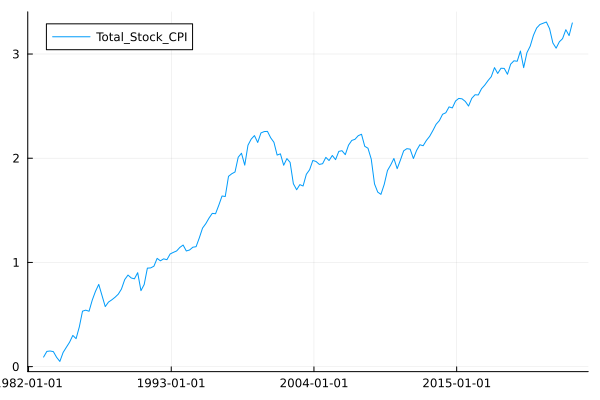

In [38]:
plot(cumsum(s_data[:Total_Stock_CPI]))

In [39]:
vmodel = VARModel(s_data)
model_summary(vmodel)

,const,Total_Stock_CPI,Price_10Y_CPI,T_Bill_CPI,Dividend_Yeld,Yeld_10Y_T_Bill,CPI,std
Total_Stock_CPI,-0.0014,0.081,0.1021,-2.2284,2.9162,-5.877,-2.89,0.0685
Price_10Y_CPI,-0.0047,-0.125,0.0259,2.5019,-0.6748,3.6542,1.6902,0.0436
T_Bill_CPI,-0.005,-0.0206,-0.0009,0.8508,-0.009,0.0778,0.7782,0.0069
Dividend_Yeld,0.0006,-0.0025,-0.003,0.0459,0.9312,0.0997,0.0601,0.0017
Yeld_10Y_T_Bill,-0.0001,0.0023,0.0069,-0.0398,0.0249,0.8812,-0.0144,0.0013
CPI,0.0051,0.0216,-0.0066,0.1372,0.0044,-0.0474,0.2061,0.0071


,Total_Stock_CPI,Price_10Y_CPI,T_Bill_CPI,Dividend_Yeld,Yeld_10Y_T_Bill,CPI
Total_Stock_CPI,1.0,0.02,0.11,-0.91,-0.13,-0.09
Price_10Y_CPI,0.02,1.0,0.41,-0.05,-0.56,-0.48
T_Bill_CPI,0.11,0.41,1.0,-0.0,-0.15,-0.99
Dividend_Yeld,-0.91,-0.05,-0.0,1.0,0.16,-0.01
Yeld_10Y_T_Bill,-0.13,-0.56,-0.15,0.16,1.0,0.08
CPI,-0.09,-0.48,-0.99,-0.01,0.08,1.0


In [40]:
bmodel = NormalWishartBVAR(s_data)
sample_posterior!(bmodel,10000, 2000)
posterior_summary(bmodel)

"Total_Stock_CPI coefficients"

Quantiles
       parameters       2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol    Float64   Float64   Float64   Float64   Float64 

            const    -0.0356   -0.0128   -0.0014    0.0102    0.0319
  Total_Stock_CPI    -0.0753    0.0273    0.0804    0.1352    0.2347
    Price_10Y_CPI    -0.1837    0.0030    0.1005    0.2017    0.3779
       T_Bill_CPI    -4.7783   -3.0716   -2.2381   -1.3945    0.2135
    Dividend_Yeld     0.9168    2.2008    2.9142    3.6459    4.9961
  Yeld_10Y_T_Bill   -10.7907   -7.5885   -5.8982   -4.2090   -0.9986
              CPI    -5.7057   -3.8502   -2.8845   -1.9615   -0.1474


"Price_10Y_CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0259   -0.0118   -0.0047    0.0028    0.0171
  Total_Stock_CPI   -0.2236   -0.1590   -0.1245   -0.0905   -0.0229
    Price_10Y_CPI   -0.1543   -0.0369    0.0258    0.0852    0.2053
       T_Bill_CPI    0.8969    1.9608    2.5029    3.0436    4.0512
    Dividend_Yeld   -1.9987   -1.1293   -0.6779   -0.2210    0.6386
  Yeld_10Y_T_Bill    0.4147    2.5639    3.6391    4.7303    6.8212
              CPI   -0.0869    1.0798    1.6790    2.2779    3.4630


"T_Bill_CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0085   -0.0062   -0.0050   -0.0039   -0.0016
  Total_Stock_CPI   -0.0366   -0.0261   -0.0206   -0.0152   -0.0048
    Price_10Y_CPI   -0.0295   -0.0107   -0.0011    0.0086    0.0267
       T_Bill_CPI    0.5985    0.7641    0.8517    0.9377    1.1021
    Dividend_Yeld   -0.2187   -0.0825   -0.0089    0.0661    0.2011
  Yeld_10Y_T_Bill   -0.4323   -0.0943    0.0818    0.2553    0.5725
              CPI    0.4963    0.6843    0.7787    0.8753    1.0566


"Dividend_Yeld coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0003    0.0003    0.0006    0.0008    0.0014
  Total_Stock_CPI   -0.0063   -0.0038   -0.0024   -0.0011    0.0013
    Price_10Y_CPI   -0.0098   -0.0054   -0.0029   -0.0005    0.0041
       T_Bill_CPI   -0.0149    0.0252    0.0461    0.0670    0.1091
    Dividend_Yeld    0.8795    0.9135    0.9314    0.9486    0.9814
  Yeld_10Y_T_Bill   -0.0214    0.0593    0.1000    0.1418    0.2218
              CPI   -0.0074    0.0377    0.0607    0.0839    0.1299


"Yeld_10Y_T_Bill coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0007   -0.0003   -0.0001    0.0002    0.0006
  Total_Stock_CPI   -0.0007    0.0013    0.0023    0.0033    0.0053
    Price_10Y_CPI    0.0014    0.0050    0.0069    0.0088    0.0123
       T_Bill_CPI   -0.0882   -0.0559   -0.0395   -0.0225    0.0085
    Dividend_Yeld   -0.0154    0.0107    0.0248    0.0385    0.0659
  Yeld_10Y_T_Bill    0.7850    0.8494    0.8815    0.9146    0.9783
              CPI   -0.0674   -0.0321   -0.0138    0.0047    0.0400


"CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const    0.0016    0.0039    0.0051    0.0063    0.0087
  Total_Stock_CPI    0.0052    0.0160    0.0215    0.0272    0.0383
    Price_10Y_CPI   -0.0353   -0.0163   -0.0063    0.0035    0.0234
       T_Bill_CPI   -0.1228    0.0475    0.1357    0.2257    0.3972
    Dividend_Yeld   -0.2121   -0.0732    0.0036    0.0803    0.2223
  Yeld_10Y_T_Bill   -0.5619   -0.2266   -0.0510    0.1284    0.4745
              CPI   -0.0826    0.1067    0.2058    0.3037    0.4913


"correlation matrix"

Quantiles
                       parameters      2.5%     25.0%     50.0%     75.0%      ⋯
                           Symbol   Float64   Float64   Float64   Float64   Fl ⋯

  Total_Stock_CPI_Total_Stock_CPI    0.0627    0.0671    0.0697    0.0726    0 ⋯
    Total_Stock_CPI_Price_10Y_CPI   -0.1399   -0.0374    0.0171    0.0718    0 ⋯
       Total_Stock_CPI_T_Bill_CPI   -0.0527    0.0521    0.1074    0.1626    0 ⋯
    Total_Stock_CPI_Dividend_Yeld   -0.9309   -0.9156   -0.9061   -0.8958   -0 ⋯
  Total_Stock_CPI_Yeld_10Y_T_Bill   -0.2784   -0.1784   -0.1244   -0.0697    0 ⋯
              Total_Stock_CPI_CPI   -0.2448   -0.1457   -0.0906   -0.0354    0 ⋯
    Price_10Y_CPI_Total_Stock_CPI   -0.1399   -0.0374    0.0171    0.0718    0 ⋯
      Price_10Y_CPI_Price_10Y_CPI    0.0398    0.0428    0.0445    0.0463    0 ⋯
         Price_10Y_CPI_T_Bill_CPI    0.2754    0.3684    0.4139    0.4581    0 ⋯
      Price_10Y_CPI_Dividend_Yeld   -0.2110   -0.1068   -0.0533    0.0009    0 ⋯
    Price_10Y_CPI

In [41]:
assets_names = colnames(s_data)
scenarios = simulate(vmodel,60)

for n in 1:6
    s_ann = annualise(scenarios[n,:,2:end],4)
    print_percentiles(s_ann,[0.05, 0.25, 0.5, 0.75, 0.95], string(assets_names[n]))
end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.1177,-0.1609,-0.1808,-0.177,-0.1829,-0.1822,-0.1833,-0.186,-0.1827,-0.1824,-0.1805,-0.1837,-0.1819,-0.183,-0.1806
0.25,0.0182,-0.0245,-0.0362,-0.0375,-0.0425,-0.0382,-0.0449,-0.0412,-0.0409,-0.0399,-0.042,-0.0378,-0.0402,-0.0445,-0.0365
0.5,0.1102,0.0701,0.06,0.0574,0.0551,0.0601,0.0563,0.0587,0.0622,0.0565,0.0606,0.0607,0.0618,0.0537,0.0607
0.75,0.204,0.1691,0.1595,0.1559,0.1518,0.1592,0.1543,0.1561,0.1599,0.1562,0.158,0.1563,0.159,0.1523,0.1597
0.95,0.337,0.305,0.2984,0.3007,0.2891,0.298,0.2988,0.2944,0.2987,0.2995,0.2953,0.2943,0.3085,0.3029,0.2985


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.1553,-0.1366,-0.1344,-0.1318,-0.1357,-0.1352,-0.1361,-0.1345,-0.1368,-0.1393,-0.136,-0.1373,-0.1374,-0.14,-0.1417
0.25,-0.072,-0.0524,-0.0472,-0.0453,-0.0441,-0.0443,-0.0456,-0.0456,-0.0463,-0.047,-0.0479,-0.0467,-0.05,-0.0473,-0.0521
0.5,-0.0156,0.0072,0.0137,0.0155,0.0164,0.0174,0.0168,0.0163,0.017,0.0156,0.015,0.0155,0.0117,0.0138,0.0128
0.75,0.0395,0.0653,0.0746,0.0759,0.0784,0.0786,0.0776,0.0793,0.0802,0.0771,0.077,0.0794,0.0753,0.0785,0.0756
0.95,0.1198,0.1533,0.1628,0.1672,0.1668,0.1686,0.1659,0.1697,0.1706,0.1694,0.1705,0.1664,0.1693,0.1668,0.1617


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0092,-0.0125,-0.017,-0.0204,-0.0235,-0.0255,-0.0276,-0.0298,-0.0311,-0.0322,-0.0333,-0.034,-0.0349,-0.0354,-0.0361
0.25,0.0044,0.0031,0.0002,-0.002,-0.0041,-0.0056,-0.0073,-0.0087,-0.0097,-0.0107,-0.0118,-0.0127,-0.0135,-0.014,-0.0141
0.5,0.0136,0.0143,0.0125,0.0109,0.0096,0.0083,0.0071,0.0058,0.005,0.004,0.0033,0.0026,0.0016,0.0013,0.0007
0.75,0.0234,0.0253,0.0249,0.0238,0.023,0.0224,0.0212,0.0197,0.0198,0.0189,0.0177,0.0174,0.0165,0.0166,0.0159
0.95,0.0373,0.0412,0.0423,0.0424,0.0429,0.0422,0.0415,0.0413,0.0408,0.0394,0.0403,0.0387,0.0381,0.0379,0.0368


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,0.0409,0.032,0.0288,0.0266,0.0262,0.026,0.0269,0.0263,0.0254,0.0264,0.0268,0.0269,0.027,0.0282,0.0279
0.25,0.0498,0.0465,0.0461,0.0464,0.0467,0.0479,0.0482,0.0488,0.0495,0.0498,0.0503,0.0508,0.0514,0.0513,0.0518
0.5,0.0559,0.0567,0.0578,0.0599,0.0613,0.0627,0.0637,0.0645,0.0651,0.0664,0.0671,0.0671,0.0675,0.0681,0.0682
0.75,0.0621,0.0667,0.07,0.0726,0.0752,0.0773,0.0788,0.0804,0.0814,0.0824,0.0832,0.0841,0.0841,0.0845,0.0851
0.95,0.0714,0.0811,0.0873,0.0922,0.0964,0.099,0.1007,0.1025,0.1041,0.1058,0.1067,0.1071,0.1079,0.109,0.1093


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0175,-0.0184,-0.018,-0.0171,-0.0164,-0.0158,-0.015,-0.0141,-0.0133,-0.0132,-0.0124,-0.0122,-0.0119,-0.0111,-0.0113
0.25,-0.0118,-0.0098,-0.008,-0.0064,-0.0047,-0.0038,-0.0029,-0.0019,-0.0013,-0.0008,-0.0001,0.0006,0.0008,0.0013,0.0016
0.5,-0.0078,-0.0039,-0.0012,0.001,0.0028,0.0043,0.0055,0.0063,0.0072,0.0078,0.0084,0.0092,0.0095,0.01,0.0102
0.75,-0.0038,0.0021,0.0059,0.0085,0.0107,0.0124,0.0137,0.015,0.0157,0.0165,0.017,0.0177,0.0183,0.0182,0.0186
0.95,0.0021,0.011,0.0159,0.0195,0.022,0.0237,0.0253,0.0271,0.0277,0.0289,0.0296,0.0302,0.0304,0.0309,0.0313


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,0.0092,0.0054,0.0043,0.0038,0.003,0.0023,0.0023,0.0023,0.0018,0.0024,0.0012,0.0019,0.0018,0.0012,0.0015
0.25,0.0238,0.0205,0.0198,0.0192,0.0188,0.0176,0.0178,0.0176,0.0174,0.0173,0.017,0.0169,0.0171,0.0168,0.017
0.5,0.0339,0.0311,0.0302,0.0295,0.0293,0.0284,0.0285,0.0285,0.0279,0.0277,0.0278,0.0275,0.0277,0.0274,0.0273
0.75,0.0442,0.0414,0.0408,0.0402,0.0396,0.0393,0.0392,0.0392,0.0385,0.0384,0.0386,0.0382,0.0382,0.0382,0.0378
0.95,0.0589,0.0564,0.056,0.0548,0.0546,0.0548,0.0545,0.0547,0.0538,0.0533,0.0533,0.0535,0.0531,0.054,0.053


In [42]:
scenarios_b = simulate(bmodel,60, 10)
for n in 1:6
    s_ann = annualise(scenarios_b[n,:,2:end],4)
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.1929,-0.4706,-0.5224,-0.5329,-0.5495,-0.5572,-0.5589,-0.566,-0.5718,-0.5765,-0.5785,-0.5821,-0.5904,-0.5957,-0.5944
0.25,0.022,-0.0695,-0.0865,-0.0948,-0.0988,-0.098,-0.0993,-0.0988,-0.1023,-0.1006,-0.102,-0.1011,-0.1023,-0.1028,-0.1029
0.5,0.1056,0.0691,0.0666,0.0647,0.0632,0.0647,0.066,0.067,0.0676,0.0676,0.0671,0.0691,0.0701,0.0695,0.0696
0.75,0.196,0.2134,0.222,0.2268,0.2295,0.2318,0.2324,0.2345,0.2381,0.2411,0.2417,0.2437,0.2458,0.2473,0.2467
0.98,0.4403,0.6326,0.6716,0.6881,0.704,0.7117,0.7219,0.7338,0.7427,0.7555,0.7665,0.7743,0.787,0.7988,0.8188


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.2567,-0.45,-0.5016,-0.5196,-0.5353,-0.5476,-0.5566,-0.5628,-0.5685,-0.5775,-0.5763,-0.5764,-0.5788,-0.5898,-0.5943
0.25,-0.0817,-0.1217,-0.1387,-0.1486,-0.1515,-0.1548,-0.1595,-0.1636,-0.1655,-0.1663,-0.1679,-0.1696,-0.1702,-0.1723,-0.1742
0.5,-0.0144,0.0066,0.0112,0.0136,0.0143,0.0152,0.0148,0.0149,0.0145,0.0126,0.0135,0.0119,0.0114,0.0114,0.0105
0.75,0.0487,0.1359,0.1619,0.1728,0.1812,0.1841,0.1888,0.1901,0.1917,0.1925,0.1934,0.1943,0.1944,0.196,0.1961
0.98,0.2036,0.455,0.5223,0.5509,0.562,0.5742,0.5855,0.5874,0.5955,0.5967,0.5986,0.6046,0.6034,0.6059,0.6144


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0488,-0.1013,-0.1304,-0.15,-0.1662,-0.1775,-0.1874,-0.1973,-0.207,-0.2152,-0.2214,-0.2293,-0.2369,-0.2436,-0.2506
0.25,-0.0061,-0.0219,-0.032,-0.0386,-0.0438,-0.0483,-0.0515,-0.0546,-0.0571,-0.0589,-0.0605,-0.0619,-0.0632,-0.0643,-0.0653
0.5,0.0138,0.014,0.0123,0.0111,0.0098,0.0087,0.0076,0.0066,0.0059,0.0053,0.0047,0.0044,0.0037,0.0038,0.0035
0.75,0.0334,0.0503,0.0574,0.0608,0.0639,0.066,0.0679,0.0689,0.0701,0.0713,0.0724,0.0726,0.0728,0.0737,0.0745
0.98,0.0771,0.1314,0.1568,0.1765,0.1892,0.2034,0.214,0.2237,0.2341,0.2424,0.2535,0.2655,0.2731,0.2852,0.2955


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,0.003,-0.0357,-0.0635,-0.0874,-0.1081,-0.1275,-0.1456,-0.1632,-0.1781,-0.1929,-0.2123,-0.2289,-0.2472,-0.2611,-0.2786
0.25,0.0389,0.0276,0.0207,0.0156,0.0113,0.0079,0.0056,0.0035,0.0015,-0.0001,-0.0023,-0.0038,-0.0053,-0.0063,-0.0076
0.5,0.0559,0.057,0.0582,0.0597,0.0609,0.0619,0.0633,0.0639,0.0641,0.0645,0.065,0.0652,0.0655,0.0649,0.0652
0.75,0.0728,0.0859,0.0956,0.1029,0.1089,0.114,0.118,0.1212,0.1241,0.1258,0.128,0.1302,0.1317,0.1325,0.1337
0.98,0.1094,0.1475,0.1755,0.1975,0.217,0.2318,0.2481,0.2579,0.2701,0.2804,0.2906,0.3,0.3079,0.3169,0.3253


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0579,-0.0822,-0.0951,-0.1038,-0.1132,-0.1215,-0.129,-0.1365,-0.1451,-0.1528,-0.1629,-0.1709,-0.1826,-0.1918,-0.2033
0.25,-0.0237,-0.0281,-0.0296,-0.03,-0.0302,-0.0308,-0.0311,-0.0313,-0.0317,-0.032,-0.0323,-0.0325,-0.0325,-0.033,-0.0335
0.5,-0.0077,-0.004,-0.001,0.0009,0.0024,0.0032,0.0042,0.005,0.0055,0.006,0.0067,0.0069,0.0071,0.0071,0.0074
0.75,0.0082,0.0201,0.0267,0.0309,0.034,0.0363,0.0383,0.0398,0.0414,0.0421,0.0428,0.0438,0.0443,0.0452,0.0454
0.98,0.0419,0.0721,0.0874,0.0982,0.1056,0.1121,0.117,0.1229,0.1272,0.1326,0.137,0.1416,0.1465,0.1492,0.1544


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,0.0025,-0.0123,-0.019,-0.0237,-0.0274,-0.0311,-0.0345,-0.038,-0.04,-0.0428,-0.0452,-0.0475,-0.0503,-0.0525,-0.0554
0.25,0.0238,0.0178,0.0158,0.0144,0.0134,0.0125,0.0118,0.0112,0.0107,0.0102,0.0099,0.0095,0.0094,0.0091,0.0089
0.5,0.0338,0.0303,0.0298,0.0293,0.0288,0.0286,0.0284,0.0283,0.0282,0.028,0.0279,0.0277,0.0277,0.0277,0.0278
0.75,0.0439,0.0435,0.0443,0.0447,0.045,0.0452,0.0455,0.046,0.0461,0.0465,0.0465,0.0464,0.0469,0.047,0.0472
0.98,0.0672,0.0777,0.0843,0.0885,0.0936,0.0966,0.1002,0.1035,0.1067,0.1091,0.1131,0.1164,0.1203,0.123,0.1267


In [57]:
# annualised compounded returns for 1, 5, 10, 15 years
for n in 1:3
    cum_ret = cumsum(scenarios[n,:,2:end]; dims=2)
    print_percentiles(expm1.(cum_ret[:,[4,20,40,60]] ./ [1 5 10 15]),[.02, .1, .25, .5, .75, .9, .98], string(assets_names[n]))    
end

,1,2,3,4
0.02,-0.1632,-0.0317,-0.0034,0.0107
0.1,-0.0631,0.0062,0.0218,0.0302
0.25,0.0184,0.0373,0.043,0.0467
0.5,0.1165,0.0736,0.0661,0.0643
0.75,0.2262,0.1114,0.0909,0.0829
0.9,0.3315,0.1465,0.1129,0.1002
0.98,0.4826,0.1934,0.1404,0.1205


,1,2,3,4
0.02,-0.1701,-0.0406,-0.0167,-0.0087
0.1,-0.1161,-0.0232,-0.0052,-0.001
0.25,-0.0695,-0.0088,0.0031,0.0054
0.5,-0.0155,0.0073,0.0121,0.0127
0.75,0.0403,0.0238,0.0211,0.02
0.9,0.0922,0.0391,0.0295,0.0267
0.98,0.1622,0.059,0.04,0.035


,1,2,3,4
0.02,-0.0153,-0.008,-0.0129,-0.0156
0.1,-0.004,-0.0006,-0.0048,-0.0076
0.25,0.0044,0.0056,0.0018,-0.0008
0.5,0.0137,0.0122,0.0091,0.0067
0.75,0.0237,0.0191,0.0166,0.0144
0.9,0.0325,0.0253,0.0232,0.0211
0.98,0.0438,0.0335,0.0316,0.03


In [58]:
for n in 1:3
    s_ann = expm1.(annualise(scenarios[n,:,2:end], 20))
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end


,1,2,3
0.02,-0.1489,-0.253,-0.2449
0.25,0.2007,0.1014,0.1087
0.5,0.4266,0.3315,0.3382
0.75,0.6954,0.6183,0.6272
0.98,1.4203,1.3867,1.3838


,1,2,3
0.02,-0.187,-0.2348,-0.2555
0.25,-0.043,-0.0304,-0.0514
0.5,0.0372,0.0861,0.0749
0.75,0.1246,0.2202,0.2138
0.98,0.3317,0.5397,0.5471


,1,2,3
0.02,-0.0394,-0.1223,-0.1512
0.25,0.0282,-0.0222,-0.0471
0.5,0.0626,0.0301,0.0097
0.75,0.0993,0.0853,0.0676
0.98,0.1789,0.2048,0.198


In [59]:
scenarios[1,:,14:26]

10000×13 Matrix{Float64}:
 -0.0465382    0.0990708   …   0.0235616   0.0631085    0.0437028
 -0.0877366   -0.0221842       0.0496219   0.0333517   -0.122691
  0.0891531   -0.207672       -0.0184556  -0.0118079    0.0658367
 -0.0327185   -0.0909363       0.0160344   0.00182712  -0.0445283
  0.0766229    0.0704623      -0.0162626  -0.0178447    0.0854946
 -0.11654     -0.0246327   …  -0.0586386   0.030467     0.0189397
  0.0395177   -0.0714395       0.119025    0.0223467   -0.0351776
  0.13388      0.0269717       0.0583454  -0.0120576    0.0638898
  0.0154776   -0.0198419       0.0145174   0.107439    -0.0623072
 -0.0156848   -0.0437751       0.0281305   0.0552621   -0.0108156
  ⋮                        ⋱   ⋮                       
  0.00943805   0.00187535      0.222741    0.101574     0.0898867
  0.0790715   -0.120499       -0.0540008   0.0683371    0.0822206
  0.0926013   -0.0613094       0.0721892  -0.00268578  -0.128605
  0.0389881    0.10447         0.133018   -0.0357161    0.0196

In [60]:
quantile(sum(scenarios[1,:,14:26], dims=2),[0.02, 0.25, 0.5, 0.75, 0.98])

5-element Vector{Float64}:
 -0.3047005736639497
  0.025655766751625085
  0.18533078600047026
  0.35057934405184643
  0.6710465271010733

In [61]:
quantile(sum(scenarios[2,:,14:26], dims=2),[0.02, 0.25, 0.5, 0.75, 0.98])

5-element Vector{Float64}:
 -0.23614296083186284
 -0.04501046422718632
  0.05408626109302045
  0.14981159119525633
  0.3407486087922818

In [62]:
s_data

164×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1983-03-01 to 2023-12-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1983-03-01 │       0.0916672 │    0.00192869 │   0.0119025 │     0.0438808 │ ⋯
│ 1983-06-01 │       0.0544534 │    -0.0072674 │  0.00796388 │     0.0416766 │ ⋯
│ 1983-09-01 │      0.00376823 │    -0.0107314 │   0.0105936 │     0.0419201 │ ⋯
│ 1983-12-01 │     -0.00592333 │   -0.00188541 │    0.012673 │     0.0427885 │ ⋯
│ 1984-03-01 │      -0.0544437 │    -0.0222866 │   0.0110268 │     0.0458333 │ ⋯
│ 1984-06-01 │      -0.0397357 │    -0.0482265 │   0.0138793 │      0.048533 │ ⋯
│ 1984-09-01 │       0.0861884 │     0.0948199 │   0.0132056 │      0.045085 │ ⋯
│ 1984-12-01 │       0.0496119 │     0.0795741 │   0.0174816 │     0.0441336 │ ⋯
│     ⋮      │        ⋮        │ 

In [63]:
 cov_m = cov(values(s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI])) 
 mu = mean(values(s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI]), dims=1) 

1×3 Matrix{Float64}:
 0.0201099  0.00836736  0.00133098

In [64]:
using Distributions
scenarios_n = zeros(3,100_000,60)

for t in 1:60
    scenarios_n[:,:,t] = rand(MvNormal(vec(mu), cov_m), 100_000)
end



In [65]:
for n in 1:3
    s_ann = expm1.(annualise(scenarios_n[n,:,2:end], 20))
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end

,1,2
0.02,-0.2153,-0.2142
0.25,0.2104,0.2112
0.5,0.4963,0.4972
0.75,0.8483,0.8499
0.98,1.8607,1.8505


,1,2
0.02,-0.2227,-0.2241
0.25,0.0276,0.0287
0.5,0.1804,0.1823
0.75,0.3581,0.3568
0.98,0.8065,0.8026


,1,2
0.02,-0.0532,-0.0526
0.25,-0.0002,0.0003
0.5,0.0269,0.0271
0.75,0.0548,0.0549
0.98,0.1134,0.114


In [66]:
returns_summarystats(data_source[:Yeld_10Y],1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Yeld_10Y,0.0292,0.1584,0.0548,0.0736,0.0066,0.9377,0.0333,0.9774,0.6945,1.8772,0.0468


In [67]:
yelds10y = dropdims(sum(scenarios[[3,5,6],:,:], dims=1), dims=1)
print_percentiles(annualise(yelds10y,4), [0.02, 0.25, 0.5, 0.75, 0.98])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,0.0291,0.0197,0.0155,0.0116,0.0094,0.007,0.0059,0.0042,0.0027,0.0017,0.002,0.0006,-0.0006,-0.0005,-0.0017
0.25,0.0359,0.0339,0.0329,0.0319,0.031,0.0302,0.0296,0.0288,0.0278,0.0275,0.0269,0.0265,0.0261,0.0262,0.0257
0.5,0.0392,0.0411,0.0417,0.0418,0.0414,0.0412,0.0409,0.0405,0.0405,0.0396,0.0393,0.0389,0.0385,0.0388,0.0382
0.75,0.0426,0.0485,0.0504,0.0515,0.0519,0.0521,0.0524,0.0525,0.0523,0.0522,0.0518,0.0519,0.0515,0.051,0.051
0.98,0.0493,0.0628,0.0676,0.0715,0.0735,0.075,0.0762,0.0767,0.0769,0.0776,0.0777,0.0771,0.0771,0.0776,0.0774


In [68]:
include("generate_bond_temp.jl")

using .Bonds

bond_returns = Bonds.scenarios_bond_returns(yelds10y, 10, 4)
bond_returns_ann = annualise(bond_returns,4)
print_percentiles(bond_returns_ann, [0.02, 0.25, 0.5, 0.75, 0.98])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0437,-0.0407,-0.0413,-0.0409,-0.0416,-0.0425,-0.0424,-0.042,-0.0434,-0.0442,-0.0426,-0.043,-0.0431,-0.0439,-0.0443
0.25,-0.0132,-0.0078,-0.0064,-0.0062,-0.0056,-0.0059,-0.0063,-0.0058,-0.0065,-0.0069,-0.0066,-0.0067,-0.0073,-0.0067,-0.0077
0.5,0.0026,0.0087,0.0107,0.0111,0.0116,0.0116,0.0117,0.0114,0.0117,0.0114,0.0113,0.0114,0.0102,0.011,0.0103
0.75,0.0182,0.0254,0.0281,0.0282,0.0289,0.0289,0.0291,0.0295,0.0295,0.0289,0.029,0.0294,0.0286,0.0292,0.0284
0.98,0.0511,0.0605,0.0638,0.0659,0.0653,0.0656,0.0656,0.0658,0.0657,0.0661,0.0656,0.0657,0.0659,0.066,0.0643


In [69]:
#cpi_ann = annualise(scenarios[6,:,2:end],4)
cpi = scenarios[6,:,2:end]
real_bond_returns = bond_returns .- cpi
print_percentiles(expm1.(annualise(real_bond_returns, 4)), [0.02, 0.25, 0.5, 0.75, 0.98])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0936,-0.0874,-0.0855,-0.0844,-0.0852,-0.0868,-0.0843,-0.085,-0.0853,-0.0857,-0.0832,-0.0845,-0.0845,-0.0843,-0.0848
0.25,-0.0522,-0.044,-0.0422,-0.0406,-0.0401,-0.0395,-0.0397,-0.0395,-0.0395,-0.0388,-0.0394,-0.0386,-0.0402,-0.0393,-0.0405
0.5,-0.0308,-0.0218,-0.0193,-0.0186,-0.0175,-0.0172,-0.0168,-0.0169,-0.016,-0.0164,-0.0169,-0.0164,-0.0175,-0.0166,-0.0171
0.75,-0.0093,0.0005,0.004,0.0046,0.0061,0.0068,0.0066,0.007,0.0076,0.0068,0.0074,0.0076,0.0065,0.0081,0.0067
0.98,0.0361,0.0503,0.0541,0.0576,0.0565,0.0578,0.0562,0.058,0.0576,0.0567,0.0585,0.0567,0.0576,0.0568,0.0565


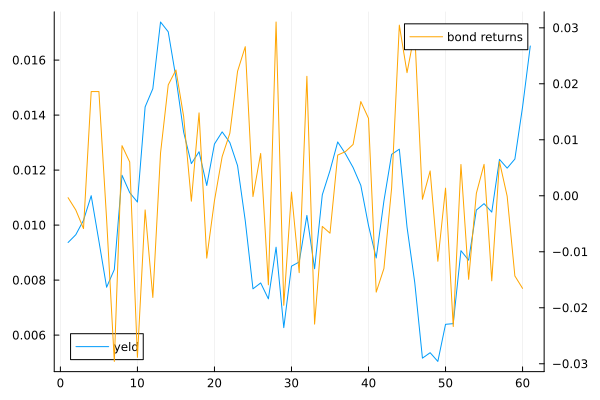

In [70]:
scenario = 13
plot(yelds10y[scenario,:], label="yeld")
plot!(twinx(), bond_returns[scenario,:], label="bond returns", color=:orange)